<a href="https://colab.research.google.com/github/louisfh/ESA_2023/blob/main/ESA_2023_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESA 2023 workshop OpenSoundscape tutorial

This tutorial will walk you through a simple example of using OpenSoundscape. We will use a Convolutional Neural Network classifier to get predictions based on audio you recorded during the workshop.

There are more tutorials available on the OpenSoundscape website  can guide you through working with Audio and Spectrograms, training a classifier, or using our signal processing algorithm RIBBIT to detect periodic vocalizations.

 http://opensoundscape.org/en/latest/

## Set up

We first need to install opensoundscape and its dependencies. This might take a minute or two. You may need to 'restart your runtime' after installation. To do this on your own machine from a terminal, you just need to run `pip install opensoundscape` in a terminal, in an environment that has a recent Python version installed.

In [1]:
!pip install opensoundscape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 846.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00
INFO: pip is looking at 

### Import OpenSoundscape
To use OpenSoundscape, we need to import the package.

In [2]:
import opensoundscape

### Load in the audio you just recorded on an AudioMoth

To work with the audio you just recorded, we will need to upload the file. If you were working with OpenSoundscape on your local machine, you wouldn't need to do this. Steps:


1.   Execute the cell below.
2.   Below the cell, click the "choose files" button and find your audio file to upload.

In [4]:
from google.colab import files

uploaded = files.upload()
files = list(uploaded.keys())
filename = files[0]

Saving pa_soundscape_60s_amplifiedto-3db.wav to pa_soundscape_60s_amplifiedto-3db.wav


If that didn't work (maybe your AudioMoth failed to record, or you couldn't upload the file) uncomment the box below and run it to download the original file we played through the speakers.

In [6]:
import gdown
url = "https://drive.google.com/file/d/1BOJtC2OpT3WNawleRcpG_e9PPTRR27cY/view?usp=drive_link"
filename = "recording_1.wav"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1BOJtC2OpT3WNawleRcpG_e9PPTRR27cY
To: /content/recording_1.wav
100%|██████████| 3.84M/3.84M [00:00<00:00, 38.2MB/s]


'recording_1.wav'

# Visualize your Audio

To visualize your audio, we will load it into an Audio object, and then display a spectrogram of the first 10 seconds. The `Audio` and `Spectrogram` classes in Opensoundscape make it easy to load in audio and visualize it.

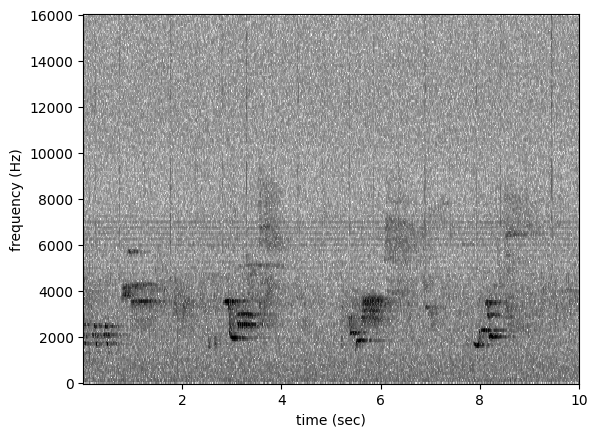

In [8]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

audio = Audio.from_file(filename)
spectrogram = Spectrogram.from_audio(audio)
spectrogram.trim(0,10).plot() # trim to just the first 10 seconds, and plot

In [10]:
# click the play button below to listen to those first 10 seconds
audio.trim(0,10)

<Audio(samples=(320000,), sample_rate=32000)>

## Use a classifier to get predictions

To save some time we've trained a model already that recognizes some of the species in your recording. This model is a Convolutional Neural Network (CNN) trained to recognize spectrograms of 16 different bird species in 4 second long spectrograms.

This classifier is definitely not perfect, but we know for some of the species it works quite well.

In [34]:
import gdown
url = "https://drive.google.com/file/d/1bONkVGykTqz0x9ikChbnqU-98PRLgk6z/view?usp=drive_link"
output = "trained.model"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1bONkVGykTqz0x9ikChbnqU-98PRLgk6z
To: /content/trained.model
100%|██████████| 44.8M/44.8M [00:00<00:00, 174MB/s]


'trained.model'

In [35]:
from opensoundscape import load_model
model = load_model("trained.model") # load the model object from the file

Let's use this model to get scores for each species its trained on. By default the model will produce scores between -infinity and +infinity for each class, with a higher score meaning the model has more confidence that that audio segment contains the species. We use a 'sigmoid' activation function to take these scores and squish them to numbers between 0 and 1. These scores represent the confidence the model has that the audio contains our species but **be aware these are not probabilities!**

You can see from how long it takes to execute this cell, that the model is able to predict on audio pretty quickly.


In [39]:
%%time
predictions = model.predict([filename],activation_layer='sigmoid')

CPU times: user 2.43 s, sys: 2.63 ms, total: 2.43 s
Wall time: 2.5 s


The names of each column below are alpha codes - shorthand abbreviations for each species. So:

`WOTH_song` = Wood Thrush song

`AMRO_song` = American Robin song

`OVEN_song` = Ovenbird song

In [48]:
predictions # take a look at the scores outputted by the model

AMRO_song     BHVI_song     BTBW_song  \
file            start_time end_time                                             
recording_1.wav 0.0        4.0       4.495110e-16  3.271380e-21  8.467767e-26   
                4.0        8.0       2.650696e-13  1.930272e-16  1.668000e-19   
                8.0        12.0      1.227990e-16  1.573719e-22  6.643783e-28   
                12.0       16.0      3.059354e-12  3.109341e-15  9.054818e-22   
                16.0       20.0      4.496965e-15  4.602657e-16  9.463128e-21   
                20.0       24.0      4.750467e-15  1.608397e-16  6.225181e-21   
                24.0       28.0      2.035771e-11  8.236824e-17  2.131589e-20   
                28.0       32.0      4.122367e-15  4.225646e-18  5.655156e-21   
                32.0       36.0      1.319894e-12  1.443646e-16  1.787058e-21   
                36.0       40.0      3.786189e-15  7.483752e-21  7.042187e-24   
                40.0       44.0      1.958815e-16  9.779839e-15  6.695283e-19   
                44.0       48.0      2.094669e-14  1.126296e-16  3.654382e-19   
                48.0       52.0      4.263166e-15  8.730568e-18  7.631118e-22   
                52.0       56.0      8.124877e-19  1.070384e-19  7.395431e-22   
                56.0       60.0      3.475961e-14  1.080046e-14  3.088601e-18   

                                        BWWA_song     GWWA_song     CAWA_song  \
file            start_time end_time                                             
recording_1.wav 0.0        4.0       9.725053e-20  7.892255e-26  1.751434e-25   
                4.0        8.0       7.755422e-17  4.210050e-20  4.599069e-19   
                8.0        12.0      6.800426e-21  3.748470e-27  1.190099e-26   
                12.0       16.0      7.486961e-18  8.566558e-21  2.278015e-20   
                16.0       20.0      4.241444e-16  1.021524e-19  1.856734e-17   
                20.0       24.0      1.080264e-16  1.224835e-19  7.875501e-19   
                24.0       28.0      1.344778e-18  2.523079e-22  2.141311e-21   
                28.0       32.0      3.919359e-16  2.302652e-21  3.266729e-21   
                32.0       36.0      1.736420e-17  1.194967e-18  1.906850e-18   
                36.0       40.0      2.628970e-20  1.022215e-25  6.880807e-26   
                40.0       44.0      1.810875e-17  2.802629e-18  9.703500e-17   
                44.0       48.0      1.976227e-17  1.116942e-18  1.648921e-17   
                48.0       52.0      8.932635e-17  1.174538e-20  7.167304e-20   
                52.0       56.0      5.900748e-20  5.280344e-20  4.287328e-19   
                56.0       60.0      1.177878e-17  1.483444e-17  3.699921e-15   

                                        CERW_song     COYE_song     EAWP_song  \
file            start_time end_time                                             
recording_1.wav 0.0        4.0       1.005410e-27  8.525029e-28  1.237651e-15   
                4.0        8.0       1.660083e-20  6.364669e-21  1.095946e-14   
                8.0        12.0      2.848725e-29  1.540247e-29  1.009400e-17   
                12.0       16.0      4.023698e-21  8.453616e-22  2.922236e-16   
                16.0       20.0      8.338830e-21  4.422340e-20  1.590787e-13   
                20.0       24.0      1.164811e-20  7.196779e-21  3.522132e-13   
                24.0       28.0      4.323717e-22  1.048139e-22  8.086697e-17   
                28.0       32.0      3.049712e-23  7.206878e-24  5.013112e-11   
                32.0       36.0      3.600250e-20  5.060441e-20  7.605481e-16   
                36.0       40.0      4.676218e-27  2.132289e-27  2.987690e-17   
                40.0       44.0      3.838932e-18  1.132236e-17  3.847060e-15   
                44.0       48.0      7.147730e-19  1.143748e-17  6.405389e-15   
                48.0       52.0      2.555500e-22  3.966546e-22  6.632837e-15   
                52.0       56.0      3.045870e-19  2.941401e-19  3.12

### Examine the scores
Lets's examine some spectrograms and their corresponding scores for the class Wood Thrush. We know from performance on some of our datasets that the Wood Thrush class performs relatively well.

In [49]:
# sort the dataframe of scores by the column "WOTH_song"
sorted_WOTH = predictions.sort_values(by="WOTH_song", ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WOTH_song score : 0.9953669309616089


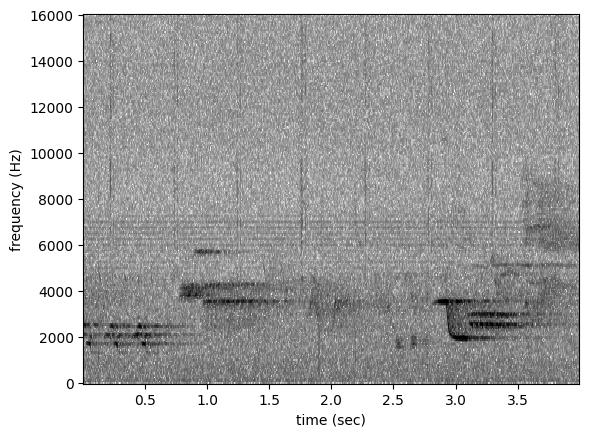

<Audio(samples=(128000,), sample_rate=32000)>

In [50]:
# display the spectrogram and the audio of the top scoring segment
(file, start_time, end_time) = sorted_WOTH.index[0] # get the filename, start and end time of the highest scoring clip
print(f"WOTH_song score : {sorted_WOTH['WOTH_song'][0]}")
audio = Audio.from_file(file, offset = start_time, duration = end_time - start_time)
Spectrogram.from_audio(audio).plot()
audio

Let's print the max score in the entire audio file for each species.

This model is far from perfect - there could well be some mistakes that the model has made, where it gives an audio segment containing a song a low score, or given a high score where the audio doesn't contain our species of interest. Depending on the kind of mistakes we see, we might go back and change how we train the model. For example if the model is confusing one species for human speech, we might need to add in examples of human speech to our training set.

In [54]:
predictions.max()

AMRO_song    2.035771e-11
BHVI_song    1.080046e-14
BTBW_song    3.088601e-18
BWWA_song    4.241444e-16
GWWA_song    1.483444e-17
CAWA_song    3.699921e-15
CERW_song    7.780759e-17
COYE_song    7.738699e-16
EAWP_song    5.013112e-11
HETH_song    3.011812e-13
OVEN_song    1.884337e-10
PRAW_song    2.101821e-18
SCTA_song    5.611162e-12
SWTH_song    8.264999e-12
VEER_song    7.586013e-15
WOTH_song    9.953669e-01
dtype: float32

## Top-down listening

Something we often do in the Kitzes lab is use our models for 'top-down listening'. We can't be sure that a high scoring clip truly does contain our species of interest, but so long as our model works reasonably well, the high scoring clips are more likely to contain our species of interest. If you want to confirm presence of a species at a site, a machine learning model can help you reduce the listening effort needed. We do this by 'listening down', starting at the highest scoring clips. Let's listen down to the 5 highest scoring clips for Ovenbird, a species that's also definitely in your recording.

Clip at time 52.0:56.0. 
 Score for OVEN_song: 1.8843371307752932e-10


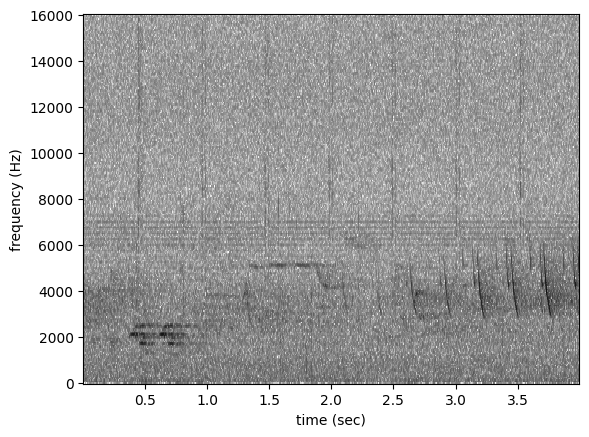

Clip at time 56.0:60.0. 
 Score for OVEN_song: 1.468211142940934e-11


In [ ]:
import IPython.display as ipd
species = "OVEN_song"
sorted = predictions.sort_values(by=species, ascending=False).head(5) # just top 5 rows

for (file, start_time, end_time), row in sorted.iterrows():
  print(f"Clip at time {start_time}:{end_time}. \n Score for {species}: {row[species]}")
  audio = Audio.from_file(file, offset = start_time, duration = end_time-start_time)
  Spectrogram.from_audio(audio).plot()
  ipd.display(ipd.Audio(audio.samples, rate = audio.sample_rate))

Repeat this analysis with a species of your choice. The text you type must exactly match one of the species names in the model, including capitalization and punctuation. See the list below for all options.

In [ ]:
model.classes

['AMRO_song',
 'BHVI_song',
 'BTBW_song',
 'BWWA_song',
 'GWWA_song',
 'CAWA_song',
 'CERW_song',
 'COYE_song',
 'EAWP_song',
 'HETH_song',
 'OVEN_song',
 'PRAW_song',
 'SCTA_song',
 'SWTH_song',
 'VEER_song',
 'WOTH_song']

In [ ]:
species = "ENTER SPECIES NAME HERE"

if sum(predictions[species] > 0.1) ==0:
  print("No scores above 0.1 for this species")

for (file,start_time,end_time), row in predictions.iterrows():
  if row[species]>0.1:
    print(f"score for {species} class [0-1]: {row[species]:0.3f}")
    spectrogram.trim(start_time,end_time).plot()
    audio = Audio.from_file(file, offset = clip_start_time, duration = 5)
    ipd.display(ipd.Audio(audio.samples, rate = 32000))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: ignored

## What is the classifier actually seeing?
Classifiers don't actually get to use the nice big spectrograms we have been plotting so far. Instead, they have to work with a much smaller image size constrained by the architecture of the model. For example the popular `ResNet` CNN architectures require `224x224` pixel images. Lets take a look at the images the model is actually making predictions on:



In [ ]:
from opensoundscape.preprocess.utils import show_tensor_grid, show_tensor
from opensoundscape.datasets import AudioSplittingDataset

ModuleNotFoundError: ignored

In [ ]:
dataset = AudioSplittingDataset([filename], model.preprocessor)
# augmentation is something that happens during training time, so we're going to turn it off here
dataset.bypass_augmentations = True

The image is really just a matrix of pixel intensity values, normalized so that they are 0-centered. Lets look at these pixel intensity values and plot the first five spectrograms as actually seen by the model.

In [ ]:
tensors = [dataset[i]['X'].expand(3,224,224) for i in range(5,10)]
tensors[0]

tensor([[[-0.5886, -0.4345, -0.4619,  ..., -0.4275, -0.5273, -0.4922],
         [-0.6528, -0.5107, -0.4950,  ..., -0.4253, -0.5498, -0.4415],
         [-0.5939, -0.5895, -0.4803,  ..., -0.4060, -0.5281, -0.4323],
         ...,
         [ 0.3346,  0.3727,  0.3471,  ...,  0.3640,  0.1523,  0.4127],
         [ 0.0829,  0.2184,  0.2771,  ...,  0.1707,  0.1008,  0.2143],
         [-0.3558,  0.0461,  0.1976,  ..., -0.0519, -0.0101,  0.0483]],

        [[-0.5886, -0.4345, -0.4619,  ..., -0.4275, -0.5273, -0.4922],
         [-0.6528, -0.5107, -0.4950,  ..., -0.4253, -0.5498, -0.4415],
         [-0.5939, -0.5895, -0.4803,  ..., -0.4060, -0.5281, -0.4323],
         ...,
         [ 0.3346,  0.3727,  0.3471,  ...,  0.3640,  0.1523,  0.4127],
         [ 0.0829,  0.2184,  0.2771,  ...,  0.1707,  0.1008,  0.2143],
         [-0.3558,  0.0461,  0.1976,  ..., -0.0519, -0.0101,  0.0483]],

        [[-0.5886, -0.4345, -0.4619,  ..., -0.4275, -0.5273, -0.4922],
         [-0.6528, -0.5107, -0.4950,  ..., -0

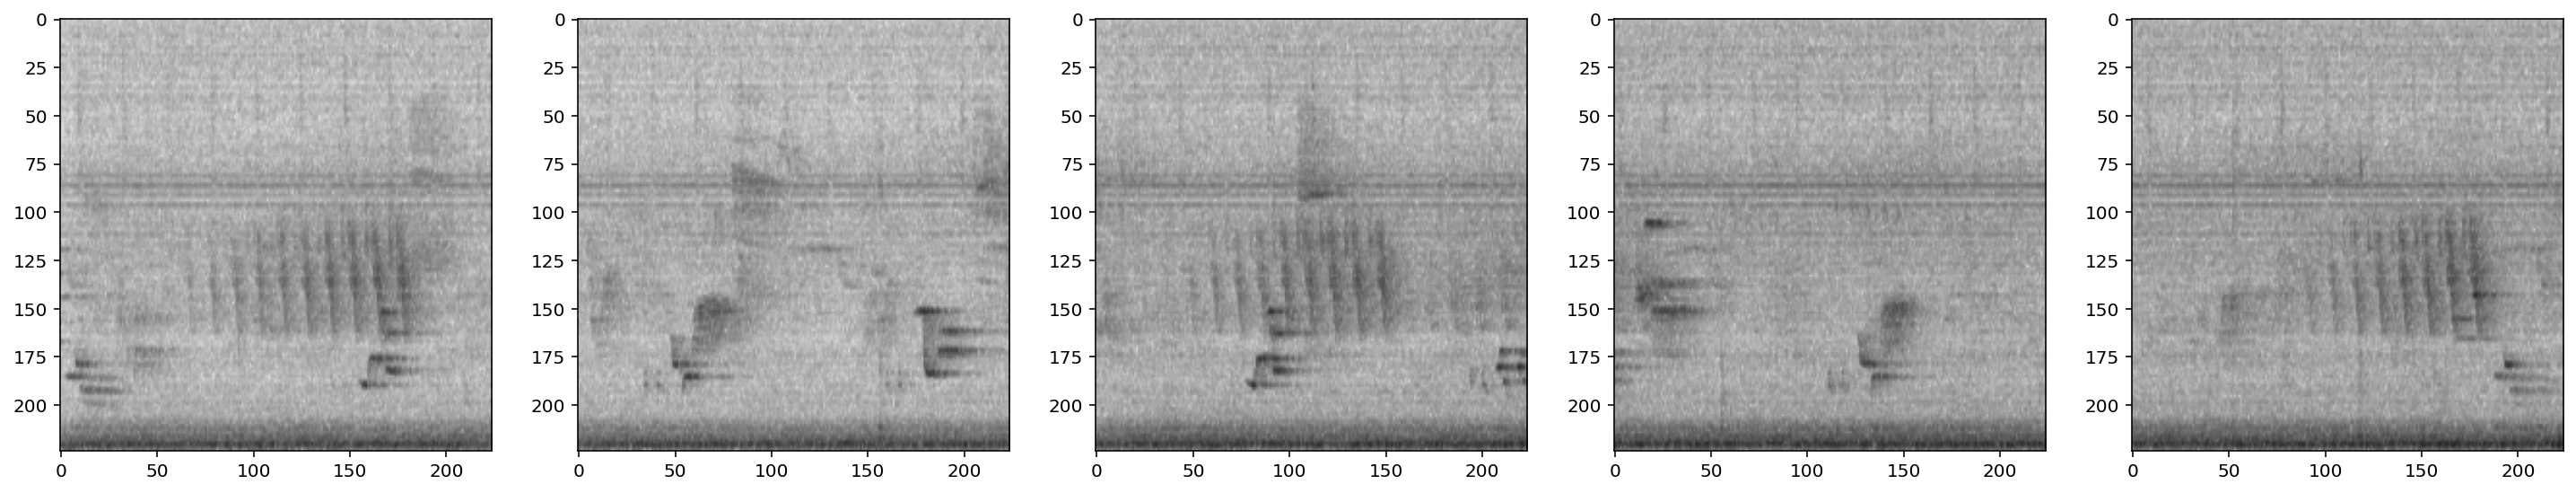

In [ ]:
_ = show_tensor_grid(tensors,5)

### Data augmentation
There are steps you can take during training to improve the performance of your classifier. An important one is data augmentation - augmenting the spectrogram images so that the effective size of the dataset increases. You can add noise, move the image off center and add bars that occlude part of the image. Ideally these augmentations make it harder for the model to just memorize examples from the training set amd instead really learn the features of the spectrogram that really identify the classes. We turn these augmentations off during prediction - but to give a sense of what these augmentations look like we've displayed some below.

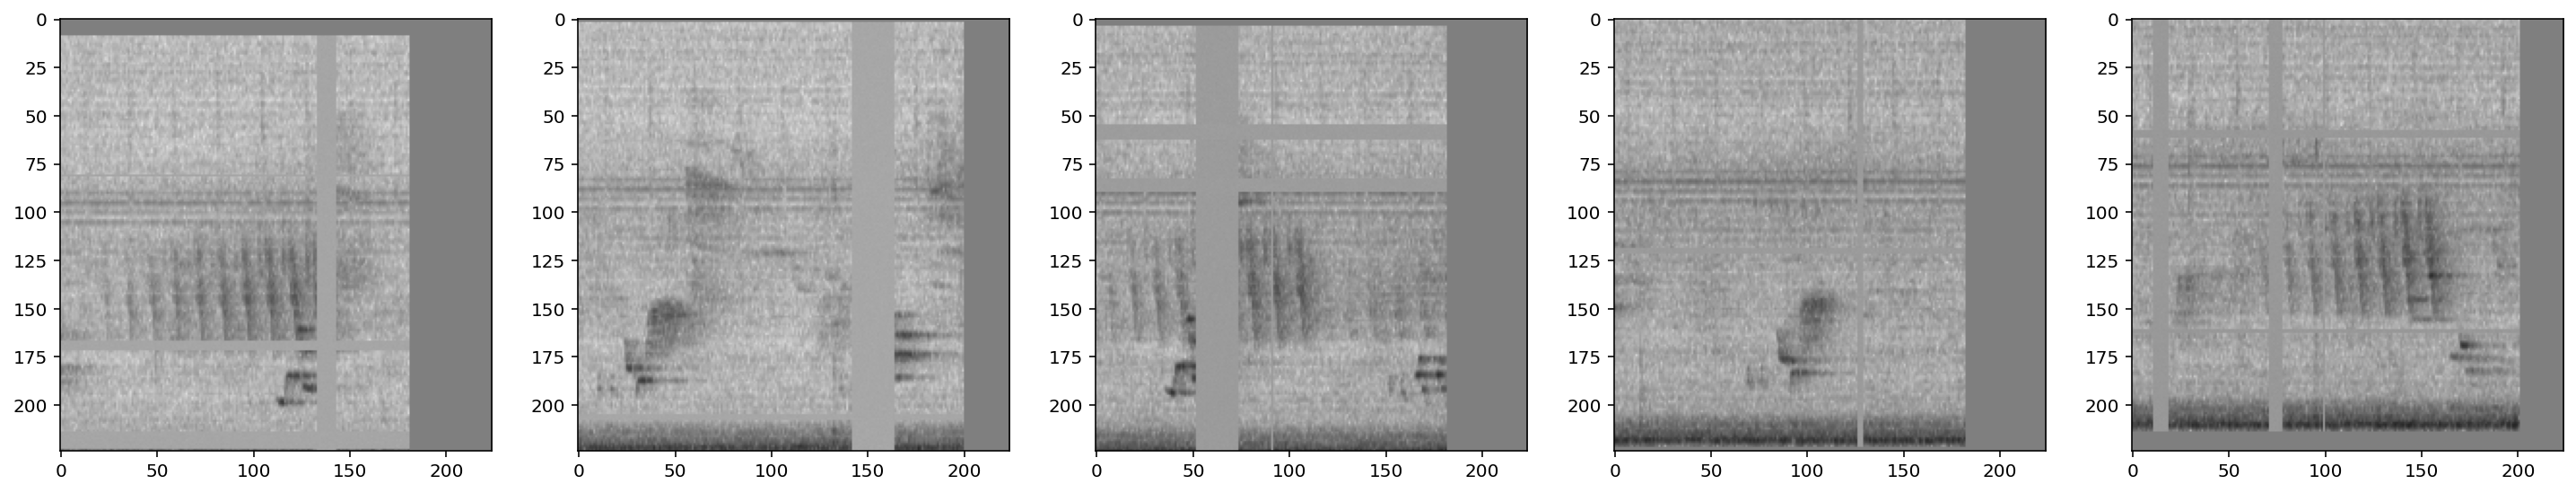

In [ ]:
dataset.bypass_augmentations = False
# We will bypass overlay here - but it allows you to overlay another sound on
# top of the current spectrogram
dataset.preprocessor.pipeline.overlay.bypass = True
tensors = [dataset[i]['X'].expand(3,224,224) for i in range(5,10)]
_ = show_tensor_grid(tensors,5)